<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_Autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocorrelation(자기상관)


* **자기상관 정의 & 공식**
  `acf_manual` 함수가 $( \rho_k=\frac{\mathrm{Cov}(X_t,X_{t-k})}{\sqrt{\mathrm{Var}(X_t)\mathrm{Var}(X_{t-k})}} )$ 를 그대로 구현합니다.
  출력으로 lag 1~5의 샘플 자기상관을 확인할 수 있어요.

* **ACF / PACF**
  `plot_acf`, `plot_pacf`로 두 그래프를 그리고, **가격 vs 수익률**의 대비를 시각적으로 보여줍니다.

* **가격은 강한 자기상관 / 수익률은 약함**
  가격 ACF는 높은 값이 길게 유지(추세), 수익률 ACF는 대부분 0 근처(시장효율적)인 것을 확인합니다.

* **Ljung–Box 검정**
  `"자기상관이 없다"`라는 귀무가설을 테스트합니다. 보통 **가격은 기각(p작음)**, **수익률은 기각 못함(p큼)** 입니다.


[*********************100%***********************]  1 of 1 completed


TSLA: 2264 prices, 2263 returns | 2015-01-02 ~ 2023-12-29

[샘플 자기상관 — 가격]  lag 1~5: [0.998 0.996 0.994 0.993 0.991]
[샘플 자기상관 — 수익률] lag 1~5: [-0.008  0.038  0.019  0.015 -0.033]

대략적 95% 유의범(가격):  ±0.041
대략적 95% 유의범(수익률): ±0.041

[ADF p-value] 가격=0.7224  |  수익률=0
(a) 가격 시계열 & ACF


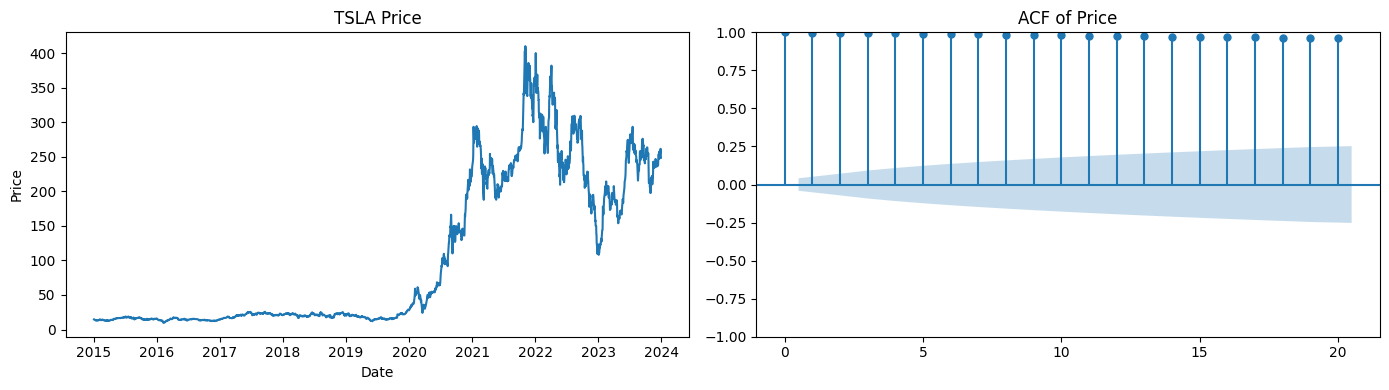

(b) 수익률 시계열 & ACF


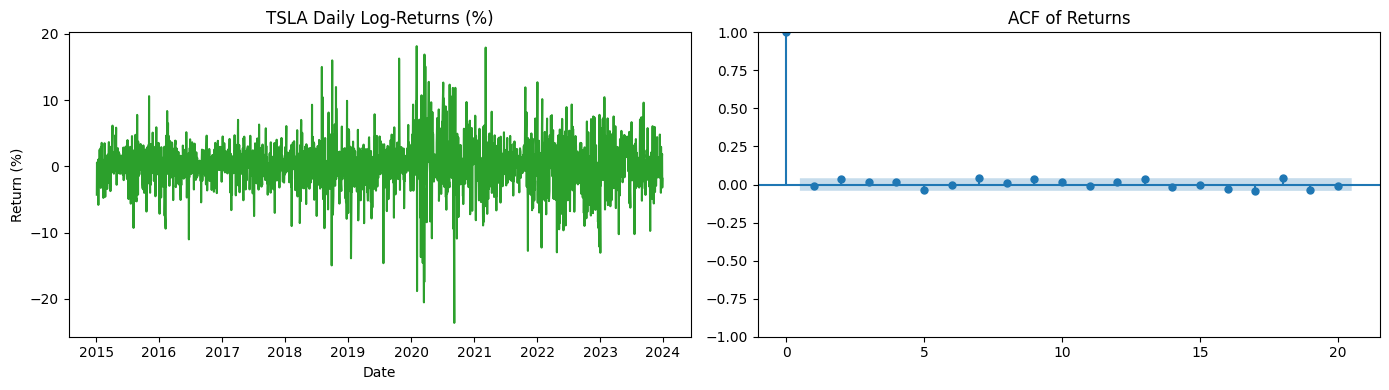

(c) 수익률의 PACF — AR 차수 진단에 도움


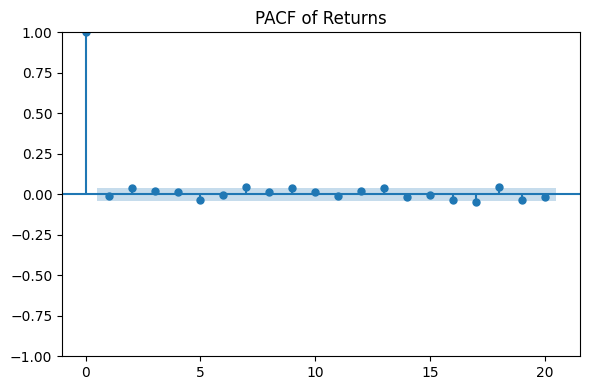


[Ljung–Box Test] 가격
         lb_stat  lb_pvalue
10  22245.062961        0.0
20  43683.077003        0.0

[Ljung–Box Test] 수익률
      lb_stat  lb_pvalue
10  15.267536   0.122608
20  34.302769   0.024148

요약
- '가격' 시계열: 강한 양(+)의 자기상관이 길게 지속 → 비정상(추세) 특성.
- '수익률' 시계열: 대부분의 지연에서 자기상관이 0에 근접 → (약)백색잡음에 가까움.
- PACF(수익률): 특정 소수의 지연이 유의하면 AR 차수 선택에 힌트를 줌.
- Ljung–Box: 수익률의 p-value가 크면 '자기상관 없음' 귀무가설을 기각하지 못함.



In [2]:
# =========================================================
# Autocorrelation / ACF / PACF 실습 (TSLA)
# ---------------------------------------------------------
# - 가격 시계열의 자기상관(높음) vs 수익률 시계열의 자기상관(거의 0)
# - ACF / PACF 그래프
# - 수식 기반 sample autocorrelation 직접 계산
# - Ljung-Box 검정(귀무: 잔차/수익률에 자기상관 없음)
# =========================================================

# !pip -q install yfinance statsmodels

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf as sm_acf, pacf as sm_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (12, 5)

# ---------------------------------------------------------
# 1) 데이터 로드: TSLA 일별 종가
# ---------------------------------------------------------
symbol = "TSLA"
start  = "2015-01-01"
end    = "2024-01-01"

df = yf.download(symbol, start=start, end=end, auto_adjust=True)
if isinstance(df.columns, pd.MultiIndex):            # yfinance가 MultiIndex를 주는 경우 방지
    df.columns = df.columns.get_level_values(0)
df = df[["Close"]].dropna().copy()
df.index = pd.to_datetime(df.index)

price = df["Close"].astype(float)
# 수익률(로그수익률, %) — 정상성 고려 시 보통 가격보다 수익률을 사용
ret = np.log(price).diff().dropna() * 100.0

print(f"{symbol}: {len(price)} prices, {len(ret)} returns | {price.index[0].date()} ~ {price.index[-1].date()}")

# ---------------------------------------------------------
# 2) ‘자기상관계수’ 수식대로 직접 계산 (샘플 ACF)
#    rho_k = Cov(X_t, X_{t-k}) / sqrt(Var(X_t) Var(X_{t-k}))
# ---------------------------------------------------------
def acf_manual(x: np.ndarray, max_lag: int):
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    v = x.var(ddof=0)
    out = [1.0]
    for k in range(1, max_lag+1):
        cov = np.dot(x[k:], x[:-k]) / len(x)
        out.append(cov / v)
    return np.array(out)

MAX_LAG = 20
rho_price  = acf_manual(price.values, MAX_LAG)
rho_return = acf_manual(ret.values,   MAX_LAG)

print("\n[샘플 자기상관 — 가격]  lag 1~5:", np.round(rho_price[1:6], 3))
print("[샘플 자기상관 — 수익률] lag 1~5:", np.round(rho_return[1:6], 3))

# 이론적 95% 유의범(대샘플 근사): ±1.96 / sqrt(N)
band_price  = 1.96 / np.sqrt(len(price))
band_return = 1.96 / np.sqrt(len(ret))
print(f"\n대략적 95% 유의범(가격):  ±{band_price:.3f}")
print(f"대략적 95% 유의범(수익률): ±{band_return:.3f}")

# ---------------------------------------------------------
# 3) ADF 단위근 검정(정상성 여부) — 가격은 비정상, 수익률은 정상에 가까움
# ---------------------------------------------------------
adf_p_price = adfuller(price.values, autolag="AIC")[1]
adf_p_ret   = adfuller(ret.values,   autolag="AIC")[1]
print(f"\n[ADF p-value] 가격={adf_p_price:.4g}  |  수익률={adf_p_ret:.4g}")

# ---------------------------------------------------------
# 4) 시각화 — 가격/수익률 시계열 + ACF + PACF(수익률)
# ---------------------------------------------------------
# (a) 가격 시계열 & ACF
print("(a) 가격 시계열 & ACF")
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(price, color="tab:blue")
axes[0].set_title(f"{symbol} Price")
axes[0].set_xlabel("Date"); axes[0].set_ylabel("Price")

plot_acf(price, lags=MAX_LAG, ax=axes[1])
axes[1].set_title("ACF of Price")
plt.tight_layout()
plt.show()

# (b) 수익률 시계열 & ACF
print("(b) 수익률 시계열 & ACF")
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(ret, color="tab:green")
axes[0].set_title(f"{symbol} Daily Log-Returns (%)")
axes[0].set_xlabel("Date"); axes[0].set_ylabel("Return (%)")

plot_acf(ret, lags=MAX_LAG, ax=axes[1])
axes[1].set_title("ACF of Returns")
plt.tight_layout()
plt.show()

# (c) 수익률의 PACF — AR 차수 진단에 도움
print("(c) 수익률의 PACF — AR 차수 진단에 도움")
fig = plt.figure(figsize=(6,4))
plot_pacf(ret, lags=MAX_LAG, method="ywm", ax=plt.gca())
plt.title("PACF of Returns")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5) Ljung–Box 검정: 귀무(H0)=자기상관 없음 → p-value가 작으면 자기상관 존재
#    - 가격: 보통 강한 자기상관 → 작은 p-value
#    - 수익률: 보통 자기상관 거의 없음 → 큰 p-value (시장 효율성 가설과 부합)
# ---------------------------------------------------------
lb_price = acorr_ljungbox(price,  lags=[10, 20], return_df=True)
lb_ret   = acorr_ljungbox(ret,    lags=[10, 20], return_df=True)
print("\n[Ljung–Box Test] 가격")
print(lb_price)
print("\n[Ljung–Box Test] 수익률")
print(lb_ret)

# ---------------------------------------------------------
# 6) 해석 가이드(간단 출력)
# ---------------------------------------------------------
print("""
요약
- '가격' 시계열: 강한 양(+)의 자기상관이 길게 지속 → 비정상(추세) 특성.
- '수익률' 시계열: 대부분의 지연에서 자기상관이 0에 근접 → (약)백색잡음에 가까움.
- PACF(수익률): 특정 소수의 지연이 유의하면 AR 차수 선택에 힌트를 줌.
- Ljung–Box: 수익률의 p-value가 크면 '자기상관 없음' 귀무가설을 기각하지 못함.
""")


In [6]:
# ============================================
# Ljung–Box: 의사결정(기각/비기각)까지 출력하는 헬퍼
# ============================================
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljungbox_report(x, name, lags=(10, 20), alpha=0.05):
    res = acorr_ljungbox(x, lags=lags, return_df=True)
    rep = res.copy()
    rep = rep.rename(columns={"lb_stat":"LB stat", "lb_pvalue":"p-value"})
    rep[f"decision@alpha={alpha}"] = np.where(
        rep["p-value"] < alpha,
        "Reject H0 → 자기상관 ‘있음’ (유의)",
        "Fail to reject H0 → 근거 부족 (유의 아님)"
    )
    print(f"\n[Ljung–Box] {name}")
    print(rep.to_string())
    return rep

# 가격(레벨)과 수익률에 대해 각각 검정
lb_price_df = ljungbox_report(price,  "Price (level)",  lags=(10, 20), alpha=0.05)
lb_ret_df   = ljungbox_report(ret,    "Log-Returns (%)", lags=(10, 20), alpha=0.05)



[Ljung–Box] Price (level)
         LB stat  p-value         decision@alpha=0.05
10  22245.062961      0.0  Reject H0 → 자기상관 ‘있음’ (유의)
20  43683.077003      0.0  Reject H0 → 자기상관 ‘있음’ (유의)

[Ljung–Box] Log-Returns (%)
      LB stat   p-value                decision@alpha=0.05
10  15.267536  0.122608  Fail to reject H0 → 근거 부족 (유의 아님)
20  34.302769  0.024148         Reject H0 → 자기상관 ‘있음’ (유의)


# Ljung–Box(륑–박스) 검정

## 무엇을 테스트하나?

* **귀무가설 H₀:** 시계열이 **백색잡음**(white noise)이다 → **선택한 여러 시차(1…h)에서 자기상관이 모두 0**
* **대립가설 H₁:** 최소 하나의 시차에서 자기상관이 0이 아니다

즉, “여러 시차의 자기상관을 한꺼번에” 검정하는 **포트만토(portmanteau)** 테스트입니다.

## 통계량

표본 크기 (n), 샘플 자기상관 (r_k) (lag k), 검정 최대 시차 (h)일 때

* **Box–Pierce 통계량(원형)**
  
  $$Q_{\text{BP}} = n \sum_{k=1}^{h} r_k^2$$
  

* **Ljung–Box 통계량(수정형, 표준)**

  $$Q_{\text{LB}} = n(n+2)\sum_{k=1}^{h}\frac{r_k^2}{,n-k,}$$
  

$(H_0)$ 하에서 $(Q_{\text{LB}} \sim \chi^2_{\nu})$ (큰 표본 근사).

* **원자료(모형 적합 전)**: $(\nu = h)$
* **ARMA/ARIMA 잔차**: $(\nu = h - m)$ (모형 추정된 모수 수 보정; 보통 (m=p+q))

## 해석법

* **p-value < α (예: 0.05)** → H₀ 기각 → “선택한 시차들 중 어딘가에 **자기상관이 유의**”
* **p-value ≥ α** → H₀ 기각 실패 → “그 정도로는 자기상관이 있다고 보기 어렵다”

> 주의: **가격(레벨)** 은 비정상/추세 때문에 대개 H₀가 **기각**됩니다.
> **수익률(또는 모형 잔차)** 이 진단용으로 적절합니다.

## 언제/어디에 쓰나?

1. **원 시계열 진단**: 가격보다는 **수익률**에서 자기상관 존재 여부 점검
2. **모형 잔차 진단**: ARIMA·SARIMA·VAR 등을 적합한 후 잔차가 백색잡음인지 검정
3. **이분산 점검 보조**: 잔차의 **제곱**(또는 절대값)에도 Ljung–Box를 적용 → **ARCH 효과** 탐지

## 시차 h 선택 요령

* 일반: 10, 20 같은 작은 여러 개를 함께 본다(보고서에 둘 다 제시)
* 표본 크기 $(n)$에 비해 너무 크지 않게: $(h \approx \sqrt{n})$ 또는 $(h \approx \log n)$ 관용
* **계절성 존재**: 계절 주기(예: 주간=5, 월간=12)의 배수를 포함해 본다(예: 12, 24)

